In [ ]:
# coding: utf-8

# In[12]:
import sys
sys.path.append('../')
import os
import numpy as np
import random
from transforms3d.euler import euler2mat, mat2euler
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib notebook')
from mpl_toolkits.mplot3d import Axes3D
import skimage.transform
import nrrd
from scipy.ndimage.filters import gaussian_filter
import glob



# In[13]:

class Synthetic(object):
    def __init__(self, N=10000):
        
        DATAPATH = "/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00"
        CASEPATH = [DATAPATH + '/' + s for s in os.listdir(DATAPATH) if s != '.DS_Store']

        self.needlepaths = []
        self.casepaths = []
        for case in CASEPATH[:N]:
            print(case+'/needle-Manual_*')
            needlepath = glob.glob(case+'/needle-*-Manual_*')
            casepath = [case + '/' + s for s in os.listdir(case) if 'case' in s]
            self.needlepaths = self.needlepaths + needlepath
            self.casepaths = self.casepaths + casepath
        print('Number of Needles:',len(self.needlepaths))
        print("Number of Cases:",len(self.casepaths))
    
        #load needles
        self.needles = []
        for needlepath in self.needlepaths[:N]:
            needleimg = nrrd.read(needlepath)
            needlearray = needleimg[0]
            needlearray[needlearray != 0] = 1
            self.needles.append(needlearray)
        
        #load cases
        self.cases = []
        for casepath in self.casepaths[:N]:
            caseimg = nrrd.read(casepath)
            casearray = caseimg[0]
            self.cases.append(casearray)

            
    def labelmap_resize(self, data, shape):
        """
        Crops from center
        """
        offset0 = (data.shape[0] - shape[0])//2
        offset1 = (data.shape[1] - shape[1])//2
        
        if data.shape[2] >= shape[2]:
            offset2 = (data.shape[2] - shape[2])//2
            out = data[offset0:offset0+shape[0], offset1:offset1+shape[1], offset2:offset2+shape[2]]
        else:
            offset2 = (shape[2] - data.shape[2])//2
            out = np.zeros(shape,int)
            out[:,:,offset2:offset2+data.shape[2]] = data[offset0:offset0+shape[0], offset1:offset1+shape[1], :]
            
        return out

    
    def get_array(self, num_needles, degree, shape, occult=True, std=None, mean=None):
        #################
        ## generate synthetic labelmap
        ##################
        random.shuffle(self.needles)
        labelmap_syn = np.zeros(shape,int)## int may need to be replaced by float
        count_needle=0
        i=-1
        while count_needle < num_needles:
            i+=1
            needle = self.needles[np.random.randint(len(self.needles))]
            xs, ys, zs = np.where(needle == 1)
            I = np.asarray([[x, y, z] for x, y, z in zip(xs,ys,zs)])
            I = np.transpose(I)
            x_angle = (random.random()-0.5)*2 *degree*np.pi/180
            y_angle = (random.random()-0.5)*2 *degree*np.pi/180
            z_angle = (random.random()-0.5)*2 *degree*np.pi/180
            R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
            try:
                M = np.transpose(np.dot(R,I)).astype(int)
            except ValueError:
                print("Empty Needle",self.needlepaths[i])
                continue
            needle_rot = np.zeros(needle.shape,int)
            for x,y,z in M:
                try:
                    needle_rot[x][y][z] = 1
                except IndexError:
                    continue
            
            
            
            needle_crop = self.labelmap_resize(needle_rot, shape)
            if np.sum(needle_crop)>800:
                count_needle+=1
                labelmap_syn = labelmap_syn + needle_crop   ## There will be chance of needle overlap
            
        if occult:
            square = np.ones((20,20,20))
            squares = np.zeros(shape)
            for i in range(20):
                sq = np.where(square!=0)
                sqx = sq[0] + np.random.randint(0,148)
                sqy = sq[1] + np.random.randint(0,148)
                sqz = sq[2] + np.random.randint(0,148)
                squares[np.clip(sqx,0,shape[0]-1), np.clip(sqy,0,shape[1]-1), np.clip(sqz,0,shape[2]-1)] = 1
            
        #################
        ## generate synthetic case
        ##################
        if std == None:
            std = np.std(self.cases[0])
        if mean == None:
            mean = np.mean(self.cases[0])
        case_syn = np.random.normal(np.log(std), mean, shape)
        case_syn = gaussian_filter(case_syn, sigma=6)
        case_syn2 = np.random.normal(np.log(std), mean, shape)
        case_syn2 = gaussian_filter(case_syn, sigma=3)
        case_syn1 = np.random.normal(np.log(std), mean, shape)
        case_syn1 = gaussian_filter(case_syn, sigma=2)
        case_syn = case_syn1*case_syn2*case_syn
        case_syn /= np.mean(case_syn)
        case_syn *= mean
        
        
        case_syn = np.clip(case_syn,0,500)
        VAL_NEEDLE = np.random.randint(np.int(np.mean(case_syn)/3))
        if occult:
            case_syn[(labelmap_syn != 0) & (squares == 0)] = VAL_NEEDLE
        else:
            case_syn[labelmap_syn != 0] = VAL_NEEDLE
        case_syn = gaussian_filter(case_syn, sigma=0.7)
    
        return labelmap_syn,case_syn
    
 

In [75]:
from scipy.ndimage.interpolation import rotate

In [85]:
labrot = rotate(labelmap, 50, axes=(0,2))

In [82]:
labelmap.astype(np.float32).shape

(148, 148, 148)

In [49]:
synthetic = Synthetic(10) 
labelmap, case = synthetic.get_array(num_needles=20, degree=10, shape = (148,148,148))


# In[21]:

#labelmap, case = synthetic.get_array(num_needles=10, degree=10, shape = (260, 320, 320))


# In[22]:



/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/033/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/077/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/076/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/014/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/062/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/044/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/022/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/034/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/008/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-

In [50]:
square = np.ones((20,20,20))
square_res = np.zeros((148,148,148))
for i in range(20):
    sq = np.where(square!=0)
    sqx = sq[0] + np.random.randint(0,148)
    sqy = sq[1] + np.random.randint(0,148)
    sqz = sq[2] + np.random.randint(0,148)
    square_res[np.clip(sqx,0,147), np.clip(sqy,0,147), np.clip(sqz,0,147)] = 1
    
square = square_res


In [51]:
print(np.unique(labelmap, return_counts=True))

(array([0, 1, 2]), array([3224849,   16636,     307]))


<IPython.core.display.Javascript object>


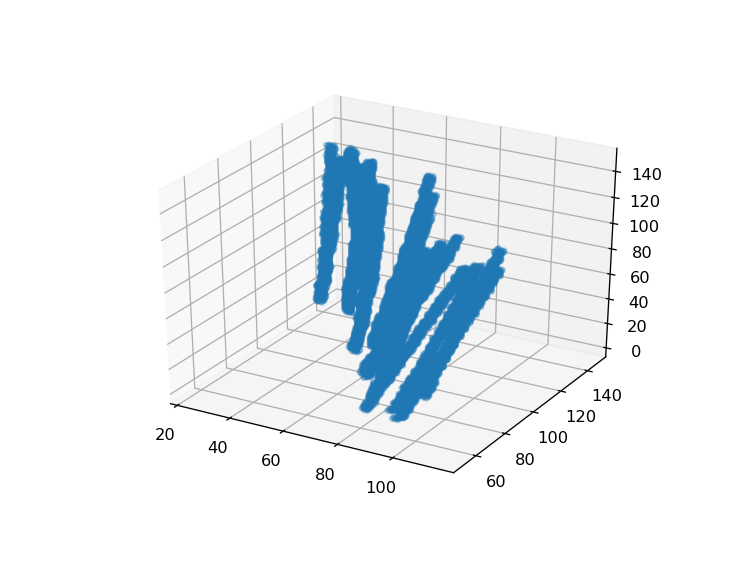

<IPython.core.display.Javascript object>


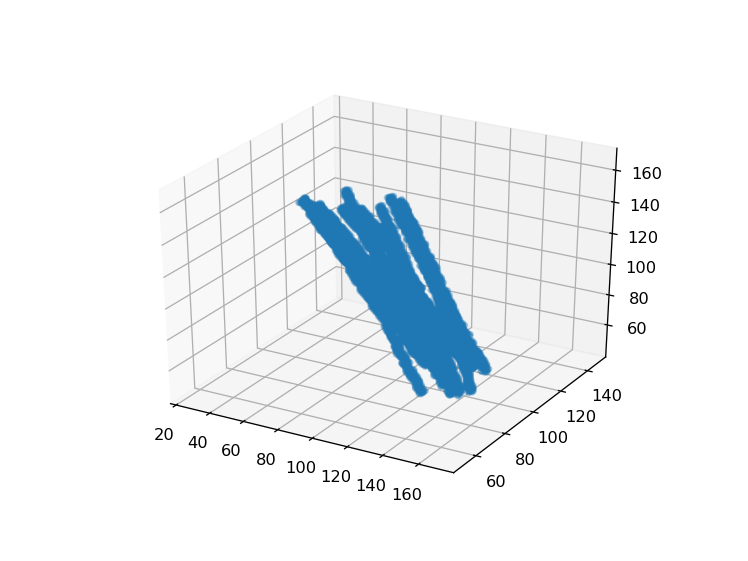

In [86]:
xs, ys, zs = np.where(labelmap != 0)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xs, ys, zs, marker='o', alpha=0.3, s=10)

xs, ys, zs = np.where(labrot != 0)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xs, ys, zs, marker='o', alpha=0.3, s=10)

<IPython.core.display.Javascript object>


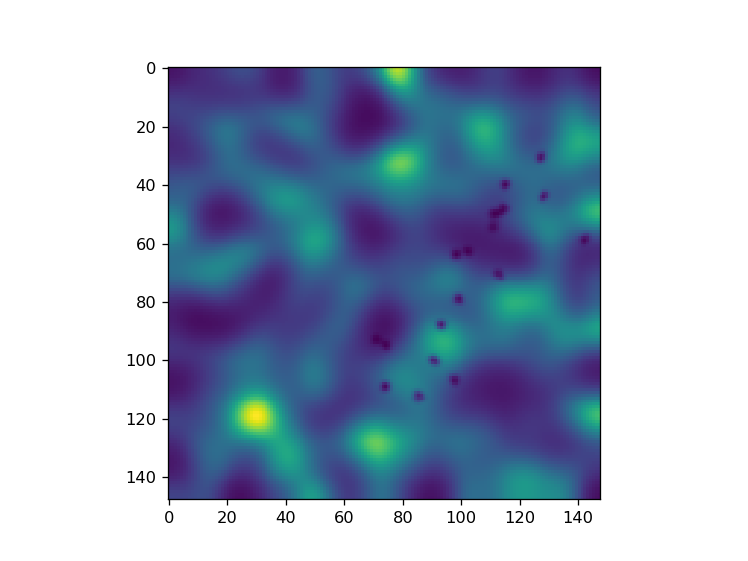

In [53]:
plt.figure()
case_ = gaussian_filter(case, sigma=0.5)
plt.imshow(case_[...,101])

In [63]:
nrrd.write('test.nrrd', case)